In [12]:
# Step 1: Install required packages
!pip install opencv-python
!pip install ultralytics
!pip install yt-dlp
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.6 MB/s eta 0:00:00


In [13]:
# Step 2: Import necessary libraries
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from collections import defaultdict
import yt_dlp
import os


In [14]:
# Step 3: Download video from YouTube (optional)
def download_youtube_video(url, output_path='./'):
    """Download YouTube video to local storage"""
    ydl_opts = {
        'format': 'best[height<=720]',  # Download best quality up to 720p
        'outtmpl': os.path.join(output_path, '%(title)s.%(ext)s'),
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        try:
            ydl.download([url])
            # Get the downloaded filename
            info = ydl.extract_info(url, download=False)
            filename = ydl.prepare_filename(info)
            return filename
        except Exception as e:
            print(f"Error downloading video: {e}")
            return None

In [15]:
# Step 4: Initialize YOLO model
def initialize_model():
    """Load pre-trained YOLO model"""
    model = YOLO('yolov8n.pt')  # Using YOLOv8 nano for faster processing
    return model

In [16]:
# Step 5: Car detection function
def detect_cars(frame, model, confidence_threshold=0.5):
    """Detect cars in a single frame"""
    results = model(frame, verbose=False)

    car_boxes = []
    car_confidences = []

    for result in results:
        boxes = result.boxes
        if boxes is not None:
            for box in boxes:
                # Get class ID and confidence
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])

                # COCO dataset class IDs for vehicles
                # 2: car, 3: motorcycle, 5: bus, 7: truck
                vehicle_classes = [2, 3, 5, 7]

                if class_id in vehicle_classes and confidence >= confidence_threshold:
                    # Get bounding box coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    car_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                    car_confidences.append(confidence)

    return car_boxes, car_confidences


In [17]:
# Step 6: Draw bounding boxes
def draw_detections(frame, boxes, confidences):
    """Draw bounding boxes around detected cars"""
    for i, (box, conf) in enumerate(zip(boxes, confidences)):
        x1, y1, x2, y2 = box

        # Draw rectangle
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label
        label = f'Vehicle {conf:.2f}'
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX,
                   0.5, (0, 255, 0), 2)

    return frame


In [18]:
# Step 7: Process video and count cars
def process_video(video_path, output_path='output_video.mp4', skip_frames=5):
    """Process entire video and count cars"""

    # Initialize model
    model = initialize_model()

    # Open video
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video")
        return None

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps//skip_frames, (width, height))

    frame_count = 0
    car_counts = []
    max_cars = 0
    total_detections = 0

    print("Processing video...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Process every nth frame to speed up processing
        if frame_count % skip_frames == 0:
            # Detect cars
            boxes, confidences = detect_cars(frame, model)
            current_car_count = len(boxes)

            # Update statistics
            car_counts.append(current_car_count)
            max_cars = max(max_cars, current_car_count)
            total_detections += current_car_count

            # Draw detections
            frame_with_detections = draw_detections(frame.copy(), boxes, confidences)

            # Add frame counter and car count
            cv2.putText(frame_with_detections, f'Frame: {frame_count}',
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(frame_with_detections, f'Cars: {current_car_count}',
                       (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Write frame
            out.write(frame_with_detections)

            # Progress update
            if frame_count % (skip_frames * 30) == 0:  # Every 30 processed frames
                progress = (frame_count / total_frames) * 100
                print(f"Progress: {progress:.1f}%")

        frame_count += 1

    # Clean up
    cap.release()
    out.release()

    # Calculate statistics
    avg_cars = np.mean(car_counts) if car_counts else 0
    processed_frames = len(car_counts)

    results = {
        'total_frames_processed': processed_frames,
        'max_cars_in_frame': max_cars,
        'average_cars_per_frame': avg_cars,
        'total_detections': total_detections,
        'car_counts_per_frame': car_counts
    }

    return results


In [19]:
# Step 8: Visualize results
def plot_results(results):
    """Create visualization of car counting results"""
    if not results or not results['car_counts_per_frame']:
        print("No results to plot")
        return

    car_counts = results['car_counts_per_frame']
    frames = range(len(car_counts))

    plt.figure(figsize=(12, 6))

    # Plot car counts over time
    plt.subplot(1, 2, 1)
    plt.plot(frames, car_counts, 'b-', linewidth=2)
    plt.title('Car Count Over Time')
    plt.xlabel('Frame Number')
    plt.ylabel('Number of Cars')
    plt.grid(True, alpha=0.3)

    # Plot histogram
    plt.subplot(1, 2, 2)
    plt.hist(car_counts, bins=max(10, max(car_counts)), alpha=0.7, color='green')
    plt.title('Distribution of Car Counts')
    plt.xlabel('Number of Cars')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    print(f"Total frames processed: {results['total_frames_processed']}")
    print(f"Maximum cars in single frame: {results['max_cars_in_frame']}")
    print(f"Average cars per frame: {results['average_cars_per_frame']:.2f}")
    print(f"Total car detections: {results['total_detections']}")
    print("="*50)


In [20]:
# Step 9: Main execution function
def main():
    """Main function to run the car counting pipeline"""

    # Option 1: Download from YouTube
    youtube_url = "https://www.youtube.com/watch?v=JiU_MXwSY3Y"
    print("Downloading video from YouTube...")
    video_path = download_youtube_video(youtube_url)

    if video_path is None:
        print("Failed to download video. Please upload a video file manually.")
        # Option 2: Use uploaded file (uncomment and modify path as needed)
        # video_path = "/content/your_video.mp4"
        return

    print(f"Video downloaded: {video_path}")

    # Process the video
    print("Starting car detection...")
    results = process_video(video_path, output_path='car_detection_output.mp4', skip_frames=3)

    if results:
        # Show results
        plot_results(results)

        print("\nProcessing complete!")
        print("Output video saved as: car_detection_output.mp4")
        print("You can download it from the Files panel in Colab")
    else:
        print("Failed to process video")


[youtube] Extracting URL: https://www.youtube.com/watch?v=JiU_MXwSY3Y
[youtube] JiU_MXwSY3Y: Downloading webpage
[youtube] JiU_MXwSY3Y: Downloading tv client config
[youtube] JiU_MXwSY3Y: Downloading player 9fe2e06e-main
[youtube] JiU_MXwSY3Y: Downloading tv player API JSON
[youtube] JiU_MXwSY3Y: Downloading ios player API JSON
[youtube] JiU_MXwSY3Y: Downloading m3u8 information
[info] JiU_MXwSY3Y: Downloading 1 format(s): 18
[download] Destination: ./Vehicle Detection and Traffic Counting using AI..mp4
[download] 100% of  609.15KiB in 00:00:00 at 871.79KiB/s 
[youtube] Extracting URL: https://www.youtube.com/watch?v=JiU_MXwSY3Y
[youtube] JiU_MXwSY3Y: Downloading webpage
[youtube] JiU_MXwSY3Y: Downloading tv client config
[youtube] JiU_MXwSY3Y: Downloading tv player API JSON
[youtube] JiU_MXwSY3Y: Downloading ios player API JSON
[youtube] JiU_MXwSY3Y: Downloading m3u8 information
Video downloaded: ./Vehicle Detection and Traffic Counting using AI..mp4
Starting car detection...
Video pr

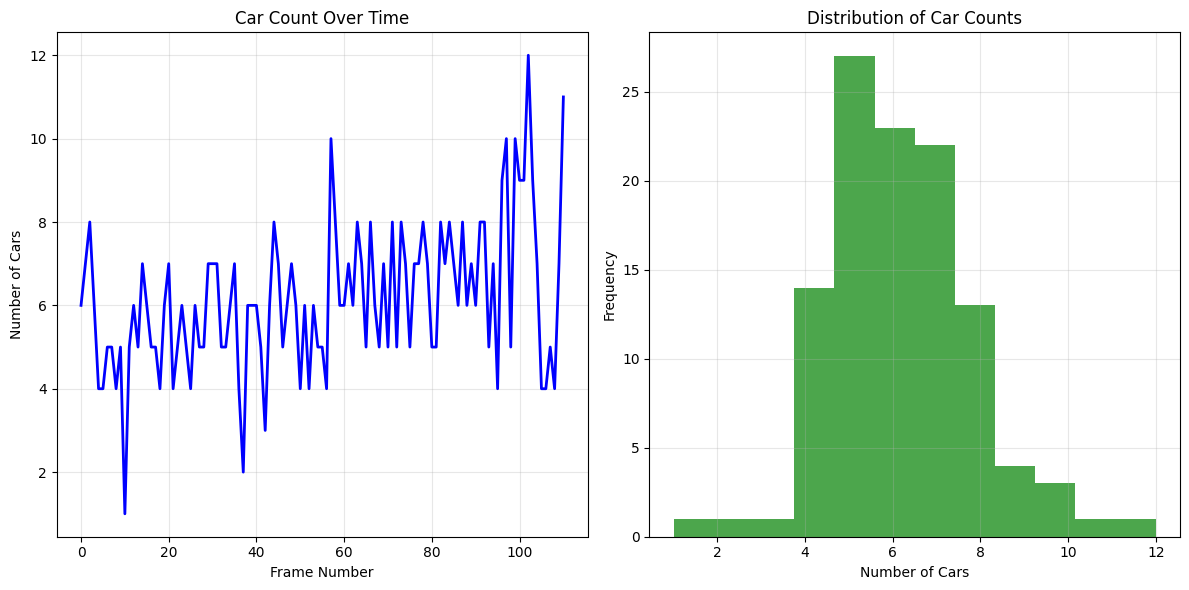


SUMMARY STATISTICS
Total frames processed: 111
Maximum cars in single frame: 12
Average cars per frame: 6.14
Total car detections: 682

Processing complete!
Output video saved as: car_detection_output.mp4
You can download it from the Files panel in Colab


In [21]:
# Step 10: Alternative function for uploaded video files
def process_uploaded_video(video_path):
    """Process an uploaded video file"""
    if not os.path.exists(video_path):
        print(f"Video file not found: {video_path}")
        return

    print(f"Processing uploaded video: {video_path}")
    results = process_video(video_path, output_path='car_detection_output.mp4', skip_frames=3)

    if results:
        plot_results(results)
        print("\nProcessing complete!")
    else:
        print("Failed to process video")

# Run the main function
if __name__ == "__main__":
    # Uncomment one of the following options:

    # Option 1: Download and process YouTube video
    main()